In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

### 프로젝트 셋팅

In [2]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_titanic.dat'
# 교차검증 횟수
cv_count = 10
# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)
# 평가 결과를 담을 리스트
# 필요하다면 다른 것도 만들어주세요
f1_score_list = []
# 학습 모델 이름
model_name_list = []

### 데이터 준비
- 데이터를 읽어오고 필요한 전처리까지 다 한다음 입력데이터는 train_X, 결과데이터는 train_y라는 변수에 담아서 준비해주세요

In [3]:
# 데이터를 읽어온다.
train_df = pd.read_csv('data/train100.csv')
test_df = pd.read_csv('data/test100.csv')

In [4]:
# 제외할 컬럼들을 제외한다.
# 만약 Fare가 없다고 오류가 나면 코드에서 Fare 없애주세요
train_df.drop(['Fare', 'FareGrade', 'CabinArea'], axis=1, inplace=True)
test_df.drop(['Fare', 'FareGrade', 'CabinArea'], axis=1, inplace=True)

display(train_df.columns)
display(test_df.columns)

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'LastName',
       'Title', 'Ages'],
      dtype='object')

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'LastName', 'Title',
       'Ages'],
      dtype='object')

In [5]:
# 두 데이터 프레임을 합친다.
all_df = pd.concat([train_df, test_df])
all_df.reset_index(inplace=True, drop=True)
all_df

,Survived,Pclass,Sex,SibSp,Parch,Embarked,LastName,Title,Ages
0,0.0,3,male,1,0,S,Braund,Mr,20.0
1,1.0,1,female,1,0,C,Cumings,Mrs,30.0
2,1.0,3,female,0,0,S,Heikkinen,Miss,20.0
3,1.0,1,female,1,0,S,Futrelle,Mrs,30.0
4,0.0,3,male,0,0,S,Allen,Mr,30.0
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,0,0,S,Spector,Mr,20.0
1305,NaN,1,female,0,0,C,Oliva y Ocana,Dona,30.0
1306,NaN,3,male,0,0,S,Saether,Mr,30.0
1307,NaN,3,male,0,0,S,Ware,Mr,20.0


In [6]:
# 문자열 -> 숫자
sex_encoder = LabelEncoder()
embarked_encoder = LabelEncoder()
lastname_encoder = LabelEncoder()
title_encoder = LabelEncoder()

sex_encoder.fit(all_df['Sex'])
embarked_encoder.fit(all_df['Embarked'])
lastname_encoder.fit(all_df['LastName'])
title_encoder.fit(all_df['Title'])

all_df['Sex'] = sex_encoder.transform(all_df['Sex'])
all_df['Embarked'] = embarked_encoder.transform(all_df['Embarked'])
all_df['LastName'] = lastname_encoder.transform(all_df['LastName'])
all_df['Title'] = title_encoder.transform(all_df['Title'])

all_df

,Survived,Pclass,Sex,SibSp,Parch,Embarked,LastName,Title,Ages
0,0.0,3,1,1,0,2,100,12,20.0
1,1.0,1,0,1,0,0,182,13,30.0
2,1.0,3,0,0,0,2,329,9,20.0
3,1.0,1,0,1,0,2,267,13,30.0
4,0.0,3,1,0,0,2,15,12,30.0
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,1,0,0,2,753,12,20.0
1305,NaN,1,0,0,0,0,593,3,30.0
1306,NaN,3,1,0,0,2,699,12,30.0
1307,NaN,3,1,0,0,2,827,12,20.0


In [7]:
# 표준화를 위해 결과데이터를 제외한다.
X = all_df.drop('Survived', axis=1)
# 표준화
scaler1 = StandardScaler()
scaler1.fit(X)

StandardScaler()

In [8]:
# 입력과 결과로 나눈다.
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [9]:
# 문자열 -> 숫자
X['Sex'] = sex_encoder.transform(X['Sex'])
X['Embarked'] = embarked_encoder.transform(X['Embarked'])
X['LastName'] = lastname_encoder.transform(X['LastName'])
X['Title'] = title_encoder.transform(X['Title'])
X

,Pclass,Sex,SibSp,Parch,Embarked,LastName,Title,Ages
0,3,1,1,0,2,100,12,20.0
1,1,0,1,0,0,182,13,30.0
2,3,0,0,0,2,329,9,20.0
3,1,0,1,0,2,267,13,30.0
4,3,1,0,0,2,15,12,30.0
...,...,...,...,...,...,...,...,...
886,2,1,0,0,2,535,15,20.0
887,1,0,0,0,2,294,9,10.0
888,3,0,1,2,2,383,9,20.0
889,1,1,0,0,0,69,12,20.0


In [10]:
# 표준화
X = scaler1.transform(X)
X

array([[ 0.84191642,  0.74349692,  0.48128777, ..., -1.28318203,
         0.39879355, -0.34966139],
       [-1.54609786, -1.34499549,  0.48128777, ..., -0.96193086,
         0.94426979,  0.39700543],
       [ 0.84191642, -1.34499549, -0.47908676, ..., -0.38602936,
        -1.23763516, -0.34966139],
       ...,
       [ 0.84191642, -1.34499549,  0.48128777, ..., -0.17447371,
        -1.23763516, -0.34966139],
       [-1.54609786,  0.74349692, -0.47908676, ..., -1.40463065,
         0.39879355, -0.34966139],
       [ 0.84191642,  0.74349692, -0.47908676, ..., -0.83656455,
         0.39879355,  0.39700543]])

In [11]:
train_X = X
train_y = y

### 기본 모델 사용하기
- 기본 모델 중에 만족하는 것을 찾았다면 하이퍼 파라미터 튜닝 과정은 생략하세요

In [12]:
# KNN
knn_basic_model = KNeighborsClassifier()
# 교차 검증을 수행한다
r1 = cross_val_score(knn_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("KNN Basic")

In [13]:
# LogisticRegression
lr_basic_model = LogisticRegression()
# 교차 검증을 수행한다
r1 = cross_val_score(lr_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("LogisticRegression Basic")

In [14]:
# SVC
svc_basic_model = SVC(probability=True)
# 교차 검증을 수행한다
r1 = cross_val_score(svc_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("SVC Basic")

In [15]:
# DecisionTree
tree_basic_model = DecisionTreeClassifier()
# 교차 검증을 수행한다
r1 = cross_val_score(tree_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("DecisionTree Basic")

In [16]:
# RandomForest
rf_basic_model = RandomForestClassifier()
# 교차 검증을 수행한다
r1 = cross_val_score(rf_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("RandomForest Basic")

In [17]:
# AdaBoost
ada_basic_model = AdaBoostClassifier()
# 교차 검증을 수행한다
r1 = cross_val_score(ada_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("AdaBoost Basic")

In [18]:
# GradientBoost
gb_basic_model = GradientBoostingClassifier()
# 교차 검증을 수행한다
r1 = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoost Basic")

In [19]:
# LGBM
lgbm_basic_model = LGBMClassifier(verbose=-1)
# 교차 검증을 수행한다
r1 = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Basic")

  File "C:\Users\lecture\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\lecture\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lecture\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\lecture\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [20]:
# XGBoost
xgboost_basic_model = XGBClassifier(verbose=-1, silent=True)
# 교차 검증을 수행한다
r1 = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Basic")

In [21]:
# HardVoting 구성
temp_model1 = KNeighborsClassifier()
temp_model2 = LogisticRegression()
temp_model3 = SVC(probability=True)
temp_model4 = DecisionTreeClassifier()
temp_model5 = RandomForestClassifier()
temp_model6 = AdaBoostClassifier()
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

hard_voting_model_list = [
    ('model1', temp_model1),
    ('model2', temp_model2),
    ('model3', temp_model3),
    ('model4', temp_model4),
    ('model5', temp_model5),
    ('model6', temp_model6),
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_basic_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 교차 검증을 수행한다
r1 = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Basic")

In [22]:
# SoftVoting 구성
temp_model1 = KNeighborsClassifier()
temp_model2 = LogisticRegression()
temp_model3 = SVC(probability=True)
temp_model4 = DecisionTreeClassifier()
temp_model5 = RandomForestClassifier()
temp_model6 = AdaBoostClassifier()
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

soft_voting_model_list = [
    ('model1', temp_model1),
    ('model2', temp_model2),
    ('model3', temp_model3),
    ('model4', temp_model4),
    ('model5', temp_model5),
    ('model6', temp_model6),
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_basic_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
r1 = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Basic")

### 하이퍼 파라미터 튜닝

In [23]:
# KNN
params = {
    'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

temp_model = KNeighborsClassifier()
knn_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
knn_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(knn_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("KNN Tuning")

In [24]:
# LogisticRegression
params = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.0001, 0.001, 0.01, 0.1, 0, 10, 100, 1000, 10000]
}

temp_model = LogisticRegression()
lr_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
lr_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(lr_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("LogisticRegression Tuning")

In [25]:
# SVC
params = {
    'C' : [0.0001, 0.001, 0.01, 0.1, 0, 10, 100, 1000, 10000]
}

temp_model = SVC(probability=True)
svc_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
svc_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(svc_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("SVC Tuning")

In [26]:
# DecisionTree
params = {
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

temp_model = DecisionTreeClassifier()
tree_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
tree_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(tree_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("DecisionTree Tuning")

In [27]:
# RandomForest
params = {
    'n_estimators' : [50, 100, 150, 200, 250, 300]
}

temp_model = RandomForestClassifier()
rf_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
rf_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(rf_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("RandomForest Tuning")

In [28]:
# AdaBoost
params = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1, 0, 10, 100, 1000, 10000]
}

temp_model = AdaBoostClassifier()
ada_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
ada_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(ada_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("AdaBoost Tuning")

In [29]:
# GradientBoosting
params = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1, 0, 10, 100, 1000, 10000]
}

temp_model = GradientBoostingClassifier()
gb_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
gb_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(gb_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoosting Tuning")

In [30]:
# LGBM
params = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1, 0, 10, 100, 1000, 10000]
}

temp_model = LGBMClassifier(verbose=-1)
lgbm_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
lgbm_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(lgbm_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Tuning")

In [31]:
# XGBoost
params = {
    'booster' : ['gbtree', 'gblinear'],
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1, 0, 10, 100, 1000, 10000]
}

temp_model = XGBClassifier(verbose=-1, silent=True)
xgboost_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1', cv=kfold)
xgboost_grid_clf.fit(train_X, train_y)

# 평가 결과를 담아준다.
f1_score_list.append(xgboost_grid_clf.best_score_)
# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Tuning")

In [32]:
# HardVoting 구성
temp_model1 = KNeighborsClassifier()
temp_model2 = LogisticRegression()
temp_model3 = SVC(probability=True)
temp_model4 = DecisionTreeClassifier()
temp_model5 = RandomForestClassifier()
temp_model6 = AdaBoostClassifier()
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

# 하이퍼 파라미터 셋팅
temp_model1.set_params(**knn_grid_clf.best_params_)
temp_model2.set_params(**lr_grid_clf.best_params_)
temp_model3.set_params(**svc_grid_clf.best_params_)
temp_model4.set_params(**tree_grid_clf.best_params_)
temp_model5.set_params(**rf_grid_clf.best_params_)
temp_model6.set_params(**ada_grid_clf.best_params_)
temp_model7.set_params(**gb_grid_clf.best_params_)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

hard_voting_model_list = [
    ('model1', temp_model1),
    ('model2', temp_model2),
    ('model3', temp_model3),
    ('model4', temp_model4),
    ('model5', temp_model5),
    ('model6', temp_model6),
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_tuning_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 교차 검증을 수행한다
r1 = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Tuning")

In [33]:
# SoftVoting 구성
temp_model1 = KNeighborsClassifier()
temp_model2 = LogisticRegression()
temp_model3 = SVC(probability=True)
temp_model4 = DecisionTreeClassifier()
temp_model5 = RandomForestClassifier()
temp_model6 = AdaBoostClassifier()
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

# 하이퍼 파라미터 셋팅
temp_model1.set_params(**knn_grid_clf.best_params_)
temp_model2.set_params(**lr_grid_clf.best_params_)
temp_model3.set_params(**svc_grid_clf.best_params_)
temp_model4.set_params(**tree_grid_clf.best_params_)
temp_model5.set_params(**rf_grid_clf.best_params_)
temp_model6.set_params(**ada_grid_clf.best_params_)
temp_model7.set_params(**gb_grid_clf.best_params_)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

soft_voting_model_list = [
    ('model1', temp_model1),
    ('model2', temp_model2),
    ('model3', temp_model3),
    ('model4', temp_model4),
    ('model5', temp_model5),
    ('model6', temp_model6),
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_tuning_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
r1 = cross_val_score(soft_voting_tuning_model, train_X, train_y, scoring='f1', cv=kfold)
# 평가 결과를 담아준다.
f1_score_list.append(r1.mean())
# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Tuning")

In [34]:
d1 = {
    'f1 score' : f1_score_list
}
result_df = pd.DataFrame(d1, index=model_name_list)
result_df.sort_values(by='f1 score', ascending=False, inplace=True)
result_df

,f1 score
AdaBoost Tuning,0.766547
AdaBoost Basic,0.764368
HardVoting Tuning,0.761270
GradientBoosting Tuning,0.755871
HardVoting Basic,0.754751
SVC Basic,0.753243
LGBM Tuning,0.753240
SoftVoting Tuning,0.750197
XGBoost Tuning,0.746993
SoftVoting Basic,0.746670


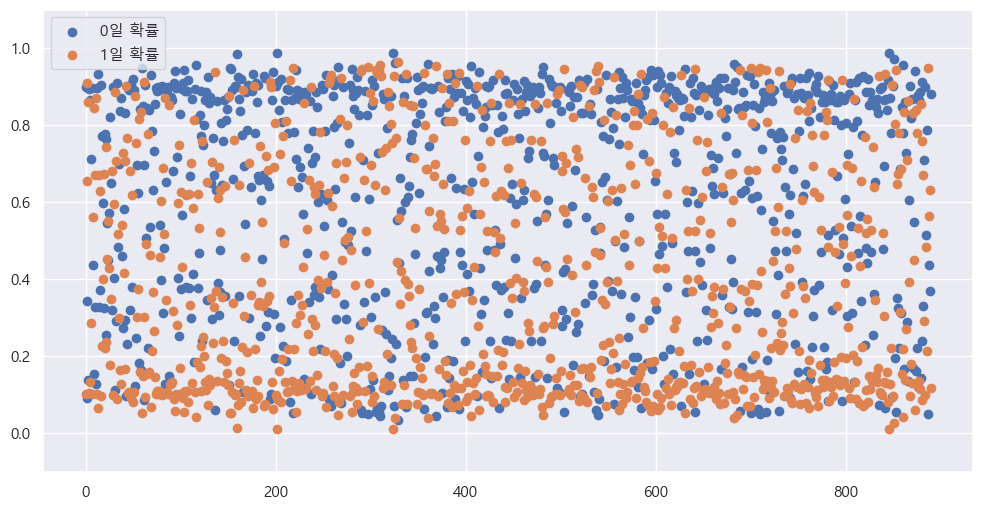

In [35]:
# 예측 결과에 대한 확률 값을 가져온다
proba_a1 = lr_grid_clf.best_estimator_.predict_proba(train_X)
# 0일 확률
a10 = proba_a1[:, 0]
# 1일 확률
a20 = proba_a1[:, 1]

plt.scatter(list(range(len(a10))), a10, label='0일 확률')
plt.scatter(list(range(len(a20))), a20, label='1일 확률')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

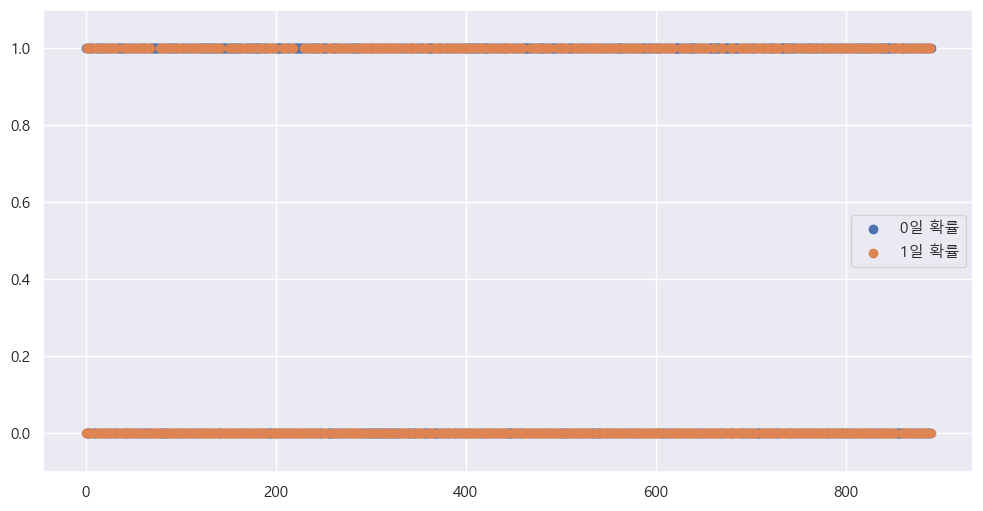

In [36]:
# 예측 결과에 대한 확률 값을 가져온다
proba_a1 = xgboost_grid_clf.best_estimator_.predict_proba(train_X)
# 0일 확률
a10 = proba_a1[:, 0]
# 1일 확률
a20 = proba_a1[:, 1]

plt.scatter(list(range(len(a10))), a10, label='0일 확률')
plt.scatter(list(range(len(a20))), a20, label='1일 확률')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

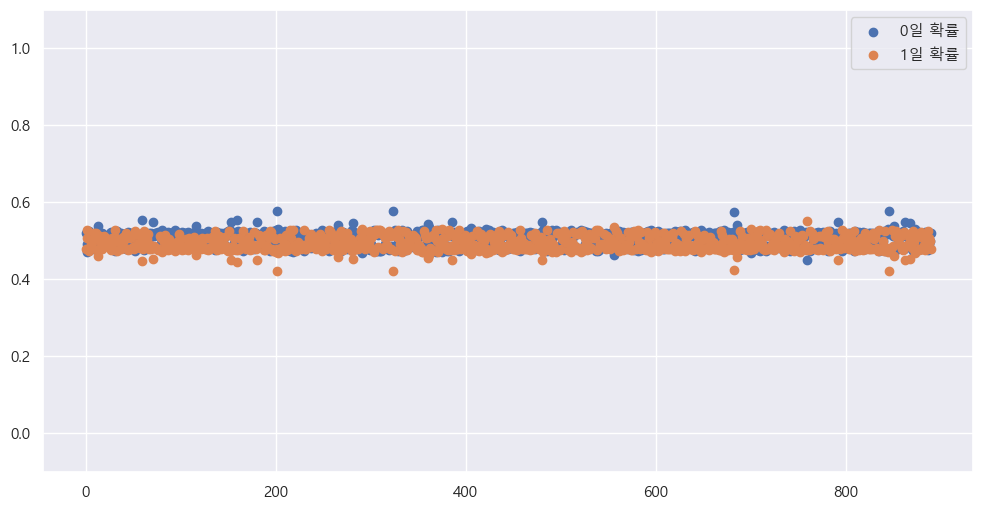

In [37]:
# 예측 결과에 대한 확률 값을 가져온다
proba_a1 = ada_grid_clf.best_estimator_.predict_proba(train_X)
# 0일 확률
a10 = proba_a1[:, 0]
# 1일 확률
a20 = proba_a1[:, 1]

plt.scatter(list(range(len(a10))), a10, label='0일 확률')
plt.scatter(list(range(len(a20))), a20, label='1일 확률')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

In [ ]:
# 최종 모델을 생성하고 전체 데이터를 학습 시킨다.
best_model = XGBClassifier()
best_model.set_params(**xgboost_grid_clf.best_params_)
best_model.fit(train_X, train_y)
best_model

In [ ]:
# 학습 모델 등을 저장한다.
with open(best_model_path, 'wb') as fp :
    pickle.dump(best_model, fp)
    pickle.dump(encoder1, fp)
    pickle.dump(scaler1, fp)

print('저장완료')

In [ ]:
# 저장 확인
with open(best_model_path, 'rb') as fp :
    test_model = pickle.load(fp)
    test_encoder = pickle.load(fp)
    test_scaler1 = pickle.load(fp)

In [ ]:
r1 = test_model.predict(train_X)
r2 = f1_score(train_y, r1)
r2